In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from tqdm import notebook
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = 'notebook'
warnings.filterwarnings(action='ignore')


station = pd.read_csv('assets\seoul_bike_station_01_12.csv',encoding='CP949',index_col=0)
near_sub = pd.read_csv('assets/near_sub_station.csv',encoding='CP949',index_col=0)
station_754 = pd.read_hdf('assets\id_754.hdf5')
con_dis= pd.read_csv('assets/con_dis.csv',encoding='CP949',index_col=0)
seoul_bike = pd.read_parquet('D:\git_local_repository\data_for_project\seoul_bike\seoul_bike_2021.parquet.gzip')

# 위도 경도로 거리측정
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m


### 데이터 전처리 id 754만 소팅

In [3]:
# #불러오기
# seoul_bike = pd.read_hdf('D:\git_local_repository\data_for_project\seoul_bike\seoul_bike_2021.hdf5')
# # id_754만 sorting
# BM = (seoul_bike['st_id1'] == 754) | (seoul_bike['st_id2'] == 754)
# sort_754 = seoul_bike[BM]

# # 754 to 754 중복 제거
# minus = sort_754.query('st_id1 == 754 & st_id2 == 754').index
# result = sort_754[~sort_754.index.isin(minus)]

# # 저장
# result.reset_index(drop=True,inplace=True)
# result.to_hdf('assets\id_754.hdf5',key='id_754')


* 754 대여소 plot
* 자주 이용하는 지하철역
* 여행지 추천
* 이용 시간대 분석

### 754 대여소 정보

In [160]:
def id_map(id,n, distance=1000, min_count = 500) :
    # 1 to 2 ex) 여의나루 => 다른 대여소
    total_num_left = seoul_bike[seoul_bike['st_id1']== id]['st_id2'].value_counts() # 현재 대여소에서 빌리면 주로 향하는 목적지는?
    total_num_left = total_num_left[: np.where(total_num_left > n)[0][-1]] # 최소 빌린 횟수 설정


    # 2 to 1 ex)다른 대여소 => 여의나루 
    total_num_right = seoul_bike[seoul_bike['st_id2']==id]['st_id1'].value_counts() # 어느 대여소에서 현재 대여소로 이동할까?
    total_num_right = total_num_right[: np.where(total_num_right > n)[0][-1]] # 최소 빌린 횟수 설정


    # concat
    result_concat = pd.concat([total_num_left,total_num_right],axis=1)
    result_concat.fillna((n/2),inplace=True)
    result_concat.rename(columns=dict(st_id2='1to2',st_id1='2to1'),inplace=True) 


    #분석에 필요한 자료 생성
    result_concat['rate'] = round((result_concat["1to2"] / (result_concat["1to2"]+result_concat["2to1"])),4) # 비율
    result_concat['diff'] = abs((result_concat["1to2"] - result_concat["2to1"])) # 1to2와 2to1 차이
    result_concat['total'] = abs((result_concat["1to2"] + result_concat["2to1"])) # 대여소 총 대여 횟수 
    result_concat['category'] = pd.cut(result_concat['rate'], bins=[0,0.45,0.55,result_concat['rate'].max()],
                                                              labels=[f"{id}가 목적지인 대여소", "이동량이 비슷한 대여소" ,f"{id}에서 주로 가는 대여소"])


    #Station 정보 추가                                                          
    add_info_result = pd.merge(result_concat,station, how='left',left_on=result_concat.index,right_on='id') # station 정보 추가
    add_info_result.loc[:,'diff'] = add_info_result['diff'] + 100  # 망할 plotly가 min_size를 구현 안해놔서 이렇게라도 해서 min을 키워야함.


    ## 해당 대여소 100미터 이내 따릉이 기록 제거(fig_1에 해당)
    add_info_result['dist'] = haversine_np(station.query('id==@id')['경도'].values,station.query('id==@id')['위도'].values,add_info_result['경도'].values,add_info_result['위도'].values) # 거리측정
    add_info_result = add_info_result.query('dist > 100')


    # 해당 대여소 1km 반경 내 따릉이 대여소 표시(fig_2에 해당)
    station_haversine = haversine_np(station.query('id==@id')['경도'].values,station.query('id==@id')['위도'].values,station['경도'].values,station['위도'].values)
    station_haversine = pd.concat([station,pd.Series(station_haversine)],axis=1)
    station_haversine.rename(columns={0:'dist'},inplace=True)
    station_haversine = station_haversine.query('@distance >= dist > 0')

    # return add_info_result <= 데이터 점검시 활용




    ### 그래프 그리기 

    # 지역 순위 표시
    fig=px.scatter_mapbox(add_info_result.query(' total > @min_count'), #category != "neutral" & 
            lat="위도",lon="경도",
            hover_name="주소2",
            hover_data=['1to2','2to1','id'],
            color='category',opacity=0.7,
            size='diff', size_max=20,
            color_discrete_map = {f'{id}가 목적지인 대여소': 'midnightblue', 
                                  '이동량이 비슷한 대여소': 'hotpink',
                                  f'{id}에서 주로 가는 대여소': 'coral'},
            zoom=12,height=500,)


    # 반경 내 따릉이 대여소 표현
    fig_2 = go.Figure(go.Scattermapbox(
                name= f'station with in {round(distance/1000,2)}km',
                lat=station_haversine['위도'],
                lon=station_haversine['경도'],
                mode='markers',
                # marker = {'size': 20, 'symbol': "bus"},
                marker=go.scattermapbox.Marker(size=8,color='black',opacity=0.2),
                text=station_haversine['주소2'],
        ))                          
    fig.add_trace(fig_2.data[0])


    # 해당 따릉이 대여소 색 표시
    fig_3 = go.Figure(go.Scattermapbox(
                name='location',
                lat=station.query('id==@id')['위도'],
                lon=station.query('id==@id')['경도'],
                mode='markers',
                # marker = {'size': 20, 'symbol': "bus"},
                marker=go.scattermapbox.Marker(size=10,color='darkgreen',opacity=0.8),
                text=station.query('id==@id')['주소2'].values,
        ))                            
    fig.add_trace(fig_3.data[0])
    fig.update_layout(mapbox_style="carto-positron")

    return fig      

In [164]:
# distance : 해당 지역 주변 따릉이 대여소 띄우기
# min_count : 대여횟수 자체가 n회 이상인 경우
# id_map(754, 10, distance=500, min_count = 50)

### 754 자주가는 지하철역 순위 / 754가 목적지인 지하철역 순위

In [76]:
# 754 근처 200m 대여소 아이디 추출

#반복문 수행 
def finding_substation(stat_id,include_st=300) :

    '''
    stat_id : 기준 대여소
    incldue_st : 기준 대여소 600미터 내 대여소 검색
    n : 대여소간 이동횟수가 최소 10회 이상인 경우만 sorting, ex) 754 to 다른대여소 중 10회 이상 이동이 있는 경우만 계산에 포함

    return : 1 to 2 이동 정보, 2 to 1 이동 정보, 시간정보
    '''


##################################


    #필수 정보 불러오기    
    station = pd.read_csv('assets/seoul_bike_station_01_12.csv',encoding='CP949',index_col=0) # 따릉이 대여소 정보
    near_sub = pd.read_csv('assets/near_sub_station.csv',encoding='CP949',index_col=0) # 지하철역 인근 따릉이 대여소 정보


    # stat_id 기준으로 반경 600m 내 대여소 찾기
    distance = haversine_np(station.loc[station['id']==stat_id,'경도'].values,
                            station.loc[station['id']==stat_id,'위도'].values,
                            station['경도'].values,
                            station['위도'].values)
    a = station.copy()
    a['distance']= distance
    a.dropna(inplace=True)
    ids = a.query('distance < @include_st').sort_values(by='distance')['id'].tolist() # 대여소 검색 결과   


    # 검색된 대여소 id 출력
    print(f'{stat_id} 대여소 기준 {include_st}m 반경 내 대여소 : {ids}')


    # seoul_bike에서 해당 대여소 자료만 추출(자료 검색을 빠르게 하기 위함!)
    reduce_case=[]
    for st_id in ids : 
        BM = (seoul_bike['st_id1'] == st_id) | (seoul_bike['st_id2'] == st_id)
        sort_754 = seoul_bike[BM]
        
        # 대여소 이동이 없는 경우 제거 ex) 754 => 754
        minus = sort_754.query('st_id1 == @st_id & st_id2 == @st_id').index
        sorting = sort_754[~sort_754.index.isin(minus)]
        reduce_case.append(sorting)

    # 이제는 원본 자료가 아닌 sorted_station을 가지고 이동량 계산
    sorted_station = pd.concat(reduce_case,axis=0)

##################################

    # 개별 대여소별 이동량 계산 후 저장
    result=[]
    for st_id in ids : 

        # ex) 기준대여소 to 다른 대여소 (1to2)
        total_num_left = sorted_station[sorted_station['st_id1']== st_id]['st_id2'].value_counts() # 기준 대여소에서 빌리면 주로 향하는 목적지는?

        # ex) 다른 대여소 to 기준대여소 (2to1) 
        total_num_right = sorted_station[sorted_station['st_id2']==st_id]['st_id1'].value_counts() # 어떤 대여소에서 기준 대여소로 이동할까?

        # 1to2, 2to1 합치기
        combine_values = pd.concat([total_num_left,total_num_right],axis=1)
        combine_values.fillna((1),inplace=True)
        combine_values.rename(columns=dict(st_id2='1to2',st_id1='2to1'),inplace=True) 
        result.append(combine_values)

    # 계산 결과 종합
    result_concat_proto= pd.concat(result,axis=0)
    result_concat= result_concat_proto.reset_index().groupby('index')[['1to2','2to1']].sum()

        # 역 주변 대여소에서 검색할 경우 에러 발생함. 관련 내용 제거
    try :
            filter_sub = near_sub.query('bike_id == @stat_id')['역사명'].iloc[0]
            filter_sub_2=near_sub.query('역사명 ==@filter_sub')['bike_id'].values
            result_concat = result_concat[~result_concat.index.isin(filter_sub_2)]
    except :
            pass
        


    # 필요 정보 추가
    result_concat['rate'] = round((result_concat["1to2"] / (result_concat["1to2"]+result_concat["2to1"])),4) # 비율
    result_concat['total'] = abs((result_concat["1to2"] + result_concat["2to1"])) # 대여소 별 총 이동 횟수 
    result_concat['category'] = pd.cut(
                                        result_concat['rate'],
                                        bins=[0,0.45,0.55,result_concat['rate'].max()],
                                        labels=["to", "sim" ,"from"]
                                    )
                                        ## to : to 754로 기억하자. 해당대여소가 754로 오는 경우가 많다. 0~0.45 => 1to2가 2to1보다 작다. 
                                        ## sim : 0.45~0.55 => 1to2와 2to1이 비슷하다. 즉 왕래가 비슷한 대여소이다.
                                        ## from : from 754로 기억하자. 754 대여소가 해당 대여소로 향하는 경우가 많음. 0.55~1 => 1to2가 2to1보다 많다.


    
    # 지하철역 인근 따릉이 대여소 정보와 종합
    sub_bike = pd.merge(result_concat, near_sub, how='left',left_on=result_concat.index,right_on='bike_id')
 

    # 이용률 top 20 대여소 선정
    sorted_sub = sub_bike.dropna(subset=['역사명']).sort_values(by='total',ascending=False)[:20]


    #기준 대여소와 역근처 대여소 직선 거리계산
    station_lat_lon = station[station['id'].isin(sorted_sub['bike_id'])][['id','주소2','위도','경도']]
    dist_to_station = haversine_np(station.loc[station['id']==stat_id,'경도'].values,
                                    station.loc[station['id']==stat_id,'위도'].values,
                                    station_lat_lon['경도'].values,
                                    station_lat_lon['위도'].values)
    station_lat_lon['distance'] = dist_to_station
    
    
    #거리정보 종합
    sorted_sub = pd.merge(sorted_sub,station_lat_lon,left_on='bike_id',right_on='id').drop(columns=['id'])

    #대여소별 예상 도착시간 계산
    result_station = []
    for station_id in sorted_sub['bike_id'] : 

        #대여소 기준 해당 역으로 가는 시간
        BM = (sorted_station['st_id2'] == station_id)
        st_id1_time = sorted_station[BM]['riding_time'].value_counts().sort_values(ascending=False)
        mean_id1 = round(st_id1_time.index[:3].values.mean(),1)

        #해당 역에서 대여소로 가는 시간
        BM = (sorted_station['st_id1'] == station_id)
        st_id2_time = sorted_station[BM]['riding_time'].value_counts().sort_values(ascending=False)
        mean_id2 = round(st_id2_time.index[:3].values.mean(),1)

        # st_id1_time.plot.bar()
        result_station.append([mean_id1,mean_id2])


    # 예상시간정보 종합 
    est_time = pd.DataFrame(result_station,columns=['대여소_to_역(분)','역_to_대여소(분)'])
    
    # return 자료 생성
    nearest_sub = pd.concat([sorted_sub.reset_index(drop=True),est_time],axis=1)
    
    one_to_two = nearest_sub.groupby('역사명')['1to2'].sum().sort_values(ascending=False) # 대여소 별 이동량 종합
    two_to_one = nearest_sub.groupby('역사명')['2to1'].sum().sort_values(ascending=False) # 대여소 별 이동량 종합

    return one_to_two, two_to_one, nearest_sub

In [74]:
one_to_two, two_to_one, nearest_sub = finding_substation(316,include_st=300)
# result_concat = finding_substation(316,include_st=300)

316 대여소 기준 300m 반경 내 대여소 : [316, 385, 3408, 368, 318, 4708]


In [82]:
from dash import dcc,html,Input, Output,dash_table

nearest_sub_sorted = nearest_sub[['역사명','bike_id','대여소_to_역(분)','역_to_대여소(분)','주소2']].iloc[:10]
data = nearest_sub_sorted.to_dict('row')
columns =  [{"name": i, "id": i,} for i in (nearest_sub_sorted.columns)]
nearest_sub_dt = dash_table.DataTable(data=data, columns=columns)

# nearest_sub_dt

In [99]:
stat_id=754
# 지역 순위 표시
fig=px.scatter_mapbox(nearest_sub.iloc[:10],
        lat="위도",lon="경도",
        hover_name="역사명",
        hover_data=['1to2','2to1','bike_id','대여소_to_역(분)','역_to_대여소(분)'],
        color='역사명',opacity=0.5,
        # size='total', size_max=20,
        zoom=12,height=500,)
fig.update_layout(mapbox_style="carto-positron")
fig.update_traces(marker={'size': 15, 'symbol' : 'star'})

# 해당 따릉이 대여소 색 표시
fig_3 = go.Figure(go.Scattermapbox(
        name='기준 대여소',
        lat=station.query('id==@stat_id')['위도'],
        lon=station.query('id==@stat_id')['경도'],
        mode='markers',
        # marker=go.scattermapbox.Marker(size=10,color='darkgreen',opacity=0.9,symbol='star'),
        text=station.query('id==@stat_id')['주소2'].values,
        ))
fig_3.update_traces(
        marker_size=12,
        marker_symbol='x',
        # marker_line=dict(width=2, color='darkgreen'),
        selector=dict(mode='markers')
    )
fig.add_trace(fig_3.data[0])

fig.update_layout(
                margin=dict(l=20, r=20, t=20, b=20),
                legend=dict(
                                yanchor="top",
                                y=0.99,
                                xanchor="right",
                                x=0.99,
                                bgcolor = 'rgba(223, 235, 223, 0.3)',
                                )



: 

In [36]:
station[station['주소2'].str.contains('을지로')]

,id,주소2,주소1,지역,위도,경도,설치일
187,320,을지로입구역 4번출구 앞,서울특별시 중구 을지로 55,중구,37.566223,126.983589,2015-10-07
195,331,을지로2가 사거리 북측,서울특별시 중구 을지로 79,중구,37.566383,126.987206,2020-07-28
196,332,을지로2가 사거리 남측,중구 을지로2가 149-10,중구,37.565990,126.987793,2015-10-07
241,389,을지로4가역 1번출구,서울특별시 중구 을지로 지하 178,중구,37.566730,126.996605,2017-08-03
248,398,을지로3가역 3번출구,중구 을지로3가 282-8,중구,37.566559,126.992439,2018-10-26
281,433,을지로입구역 2번출구,중구 을지로1가 118,중구,37.566345,126.982292,2018-12-14
316,473,을지로4가역 9번출구,을지로 170,중구,37.566051,126.997986,2020-03-01
2482,4761,탐앤탐스 을지로3가점,초동 107-9,중구,37.564671,126.990883,2020-10-19
2488,4774,을지로입구역 8번출구,을지로1가 140-1,중구,37.565903,126.981781,2020-09-23
2489,4775,을지로지하쇼핑센터,을지로1가 199-80,중구,37.565990,126.984276,2020-09-24


### 여행지 추천

In [181]:
def searching_location(wanting_ids,min_time=1,max_time=200,min_count=5) : 

    # 해당 지역에서 이동하는 지역 소팅
    sorted_st_id2=station_754[station_754['st_id1'] == wanting_ids]['st_id2'].value_counts() 
    over_count=np.where(sorted_st_id2 >= min_count)[0][-1]


    # 정보 표시
    print(f'검색기준 : 해당 대여소와 최소 {min_count}번 이상 대여기록이 있는 대여소 검색')
    print(f'총 {over_count}개 대여소 확보')


    result_station = []
    for station_id in notebook.tqdm(sorted_st_id2[:over_count].index) : 
        '''
            iterate 결과
            10.66it/s 1083.75mb
            7.28it/s 1101.96mb
            5.12it/s 1099.29mib
        '''
        
        # 가장 단순하지만 loop에서 9.21 it/s로 제일빠름
        BM = (station_754['st_id1'] == wanting_ids) & (station_754['st_id2'] == station_id)
        filter_id = station_754[BM]['riding_time'].value_counts().sort_values(ascending=False)
        
        # 여러 값을 한 번에 계산한다는 장점이 있지만 상대적으로 느림 Loop 7.44 it/s
        # BM = (station_754['st_id1'].isin([wanting_ids])) & ((station_754['st_id2'].isin([station_id])))
        # filter_id = station_754['riding_time'][BM].value_counts().sort_values(ascending=False)

        # 시각적으로 직관적이고 간단하게 작성할 수 있음. 그러나 Loop 3.21 it/s 임. 심한 경우 1.44 it/s인 경우도 발생
        # filter_id = station_754.query('st_id1 == @wanting_ids & st_id2 == @station_id')['riding_time'].value_counts().sort_values(ascending=False)

        # 에러 방지차원
        try :
            mean = round(filter_id.index[:3].values.mean(),1)
            percent = round(sum(filter_id[:3].values)/sum(filter_id),2)
            num = sum(filter_id[:3])
            total_num = sum(filter_id)
            result_station.append([station_id,mean,percent,num,total_num])
        except :
            pass
    
    # 자료정리
    sorted_ids = pd.DataFrame(result_station,columns=['id','est_time','percent','num','total_num']).query('num > 10 & @min_time <= est_time <= @max_time')
    sorted_ids.columns = ['id', '예상도착시간', '비율','예상시간 내 도착 횟수' ,'대여소 이용 이력']
    return pd.merge(sorted_ids, station, how='left', on='id').sort_values(by='예상도착시간',ascending=False)

### 시간대별 대여소 분석

In [10]:
# 2021년 휴일 데이터 구해서 평일만 구해보면 출퇴근 시간이 극명하게 갈리려나?
# 주거지역이다보니 출근과는 상관있는데 퇴근과는 상관 없어 보이는듯.
# station_754['hour_period']=station_754['time'].apply(lambda x : str(x.hour)  + '~' +   str(x.hour+1))

### 시간

<AxesSubplot:xlabel='hour_period'>

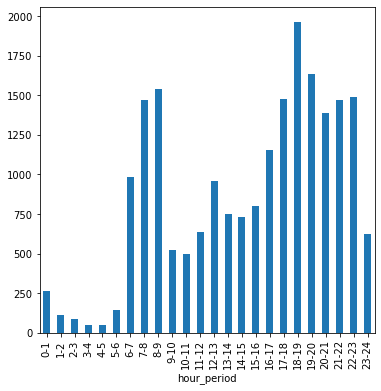

In [79]:
plt.figure(figsize=(6,6))
station_754[~station_754['weekday'].isin([5,6])].groupby('hour_period').size().plot.bar()
# plt.ylim(0,2500)

### 요일별

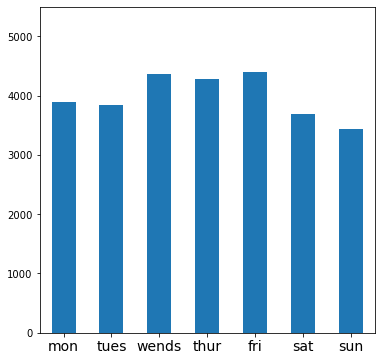

In [80]:
plt.figure(figsize=(6,6))
station_754['weekday'].value_counts().sort_index().plot.bar()

plt.ylim(0,5500)
plt.xticks([0,1,2,3,4,5,6],['mon','tues','wends','thur','fri','sat','sun'],fontsize=14,rotation=0)
plt.show()

### 월별

<AxesSubplot:>

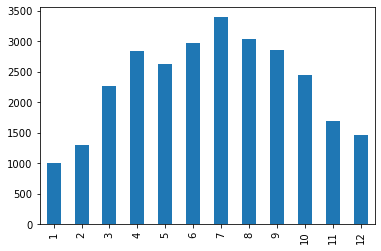

In [76]:
station_754['month'].value_counts().sort_index().plot.bar()

### 시간별 대여소 이동량 변화 측정

In [175]:
# 우리집 대여소 분석에 시간대별 변화량 기능 추가

# 대여소 거리측정(haversine 방식이라고 함..)




def id_map(id,n=1, distance=1000, min_count = 50,weekday=list(range(7))) :
    # 시간대 나누기
    station_754['hour_period']=station_754['time'].apply(lambda x : str(x.hour)  + '~' +   str(x.hour+1))

    time=[f'{i}~{i+1}' for i in range(24)]

    merge_all =[]
    for hour_period in time :
        station_sorted = station_754[(station_754['hour_period'] == hour_period) & station_754['weekday'].isin(weekday)]
        # 1 to 2 ex) 여의나루 => 다른 대여소
        total_num_left = station_sorted[station_sorted['st_id1']== id]['st_id2'].value_counts() # 현재 대여소에서 빌리면 주로 향하는 목적지는?
        # total_num_left = total_num_left[: np.where(total_num_left > n)[0][-1]] # 최소 빌린 횟수 설정


        # 2 to 1 ex)다른 대여소 => 여의나루 
        total_num_right = station_sorted[station_sorted['st_id2']==id]['st_id1'].value_counts() # 어느 대여소에서 현재 대여소로 이동할까?
        # total_num_right = total_num_right[: np.where(total_num_right > n)[0][-1]] # 최소 빌린 횟수 설정


        # concat
        result_concat = pd.concat([total_num_left,total_num_right],axis=1)
        result_concat.fillna((n/2),inplace=True)
        result_concat.rename(columns=dict(st_id2='1to2',st_id1='2to1'),inplace=True) 


        #분석에 필요한 자료 생성
        result_concat['rate'] = round((result_concat["1to2"] / (result_concat["1to2"]+result_concat["2to1"])),4) # 비율
        result_concat['diff'] = abs((result_concat["1to2"] - result_concat["2to1"])) # 1to2와 2to1 차이
        result_concat['total'] = abs((result_concat["1to2"] + result_concat["2to1"])) # 대여소 총 대여 횟수 
        result_concat['hour_period'] = hour_period
        
        try : 
            result_concat['category'] = pd.cut(result_concat['rate'], bins=[0,0.45,0.55,result_concat['rate'].max()],
                                                                labels=[f"{id}가 목적지인 대여소", "이동량이 비슷한 대여소" ,f"{id}에서 주로 가는 대여소"])
        except :
            # result_concat['category'] = '대여기록 없음'                                       
            print(id)
            # pass

        #Station 정보 추가                                                          
        add_info_result = pd.merge(result_concat,station, how='left',left_on=result_concat.index,right_on='id') # station 정보 추가
        add_info_result.loc[:,'diff'] = add_info_result['diff'] + 100  # 망할 plotly가 min_size를 구현 안해놔서 이렇게라도 해서 min을 키워야함.


        ## 해당 대여소 100미터 이내 따릉이 기록 제거(fig_1에 해당)
        add_info_result['dist'] = haversine_np(station.loc[station['id']==id,'경도'].values,station.loc[station['id']==id,'위도'].values,add_info_result['경도'].values,add_info_result['위도'].values) # 거리측정
        add_info_result = add_info_result[add_info_result['dist'] > 100]
        
        #모으기
        merge_all.append(add_info_result)

    # 합치기
    add_info_result = pd.concat(merge_all,axis=0)

    ### 그래프 그리기 

    # 지역 순위 표시
    fig=px.scatter_mapbox(add_info_result[add_info_result['total'] > min_count],
            lat="위도",lon="경도",
            hover_name="주소2",
            hover_data=['1to2','2to1','id'],
            color='category',opacity=0.7,
            size='total', size_max=20,
            color_discrete_map = {f'{id}가 목적지인 대여소': 'midnightblue', 
                                  '이동량이 비슷한 대여소': 'hotpink',
                                  f'{id}에서 주로 가는 대여소': 'coral'},
            animation_frame='hour_period',
            # animation_group='total',
            zoom=11,height=500,)


    # # 해당 대여소 1km 반경 내 따릉이 대여소 표시(fig_2에 해당)
    # station_haversine = haversine_np(station.loc[station['id']==id,'경도'].
    #                                  values,station.loc[station['id']==id,'위도'].values,
    #                                  station['경도'].values,
    #                                  station['위도'].values
    #                                  )
                                     
    # station_haversine = pd.concat([station,pd.Series(station_haversine)],axis=1)
    # station_haversine.rename(columns={0:'dist'},inplace=True)
    # station_haversine = station_haversine.query('@distance >= dist > 0')

    # # 반경 내 따릉이 대여소 표현
    # fig_2 = go.Figure(go.Scattermapbox(
    #             name= f'station with in {round(distance/1000,2)}km',
    #             lat=station_haversine['위도'],
    #             lon=station_haversine['경도'],
    #             mode='markers',
    #             # marker = {'size': 20, 'symbol': "bus"},
    #             marker=go.scattermapbox.Marker(size=8,color='black',opacity=0.2),
    #             text=station_haversine['주소2'],
    #     ))                          
    # fig.add_trace(fig_2.data[0])


    # 해당 따릉이 대여소 색 표시
    fig_3 = go.Figure(go.Scattermapbox(
                name='location',
                lat=station.query('id==@id')['위도'],
                lon=station.query('id==@id')['경도'],
                mode='markers',
                # marker = {'size': 20, 'symbol': "bus"},
                marker=go.scattermapbox.Marker(size=10,color='darkgreen',opacity=0.8),
                text=station.query('id==@id')['주소2'].values,
        ))                            
    fig.add_trace(fig_3.data[0])
    fig.update_layout(mapbox_style="carto-positron")

    return fig

# id_map(754,n=1,distance=1000, min_count = 20, weekday=list(range(7)))